# **Imports**

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, precision_score, classification_report, f1_score, roc_auc_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, chi2, mutual_info_classif
from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import itertools

drive.mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


# Loading data

In [4]:
file_path = '/content/drive/MyDrive/ass2.pickle'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

X_train = np.array(data['train'].iloc[:,:-1].values)
y_train = np.array(data['train'].iloc[:,-1:].values)

X_val = np.array(data['dev'].iloc[:,:-1].values)
y_val = np.array(data['dev'].iloc[:,-1:].values)

X_test = np.array(data['test'].iloc[:,:-1].values)
y_test = np.array(data['test'].iloc[:,-1:].values)



# Preliminary Data Analysis

In [ ]:
print(f"size of train: {len(data['train'])}")
print(f"size of test: {len(data['test'])}")
print(f"size of dev: {len(data['dev'])}")

size of train: 40533
size of test: 13512
size of dev: 13512


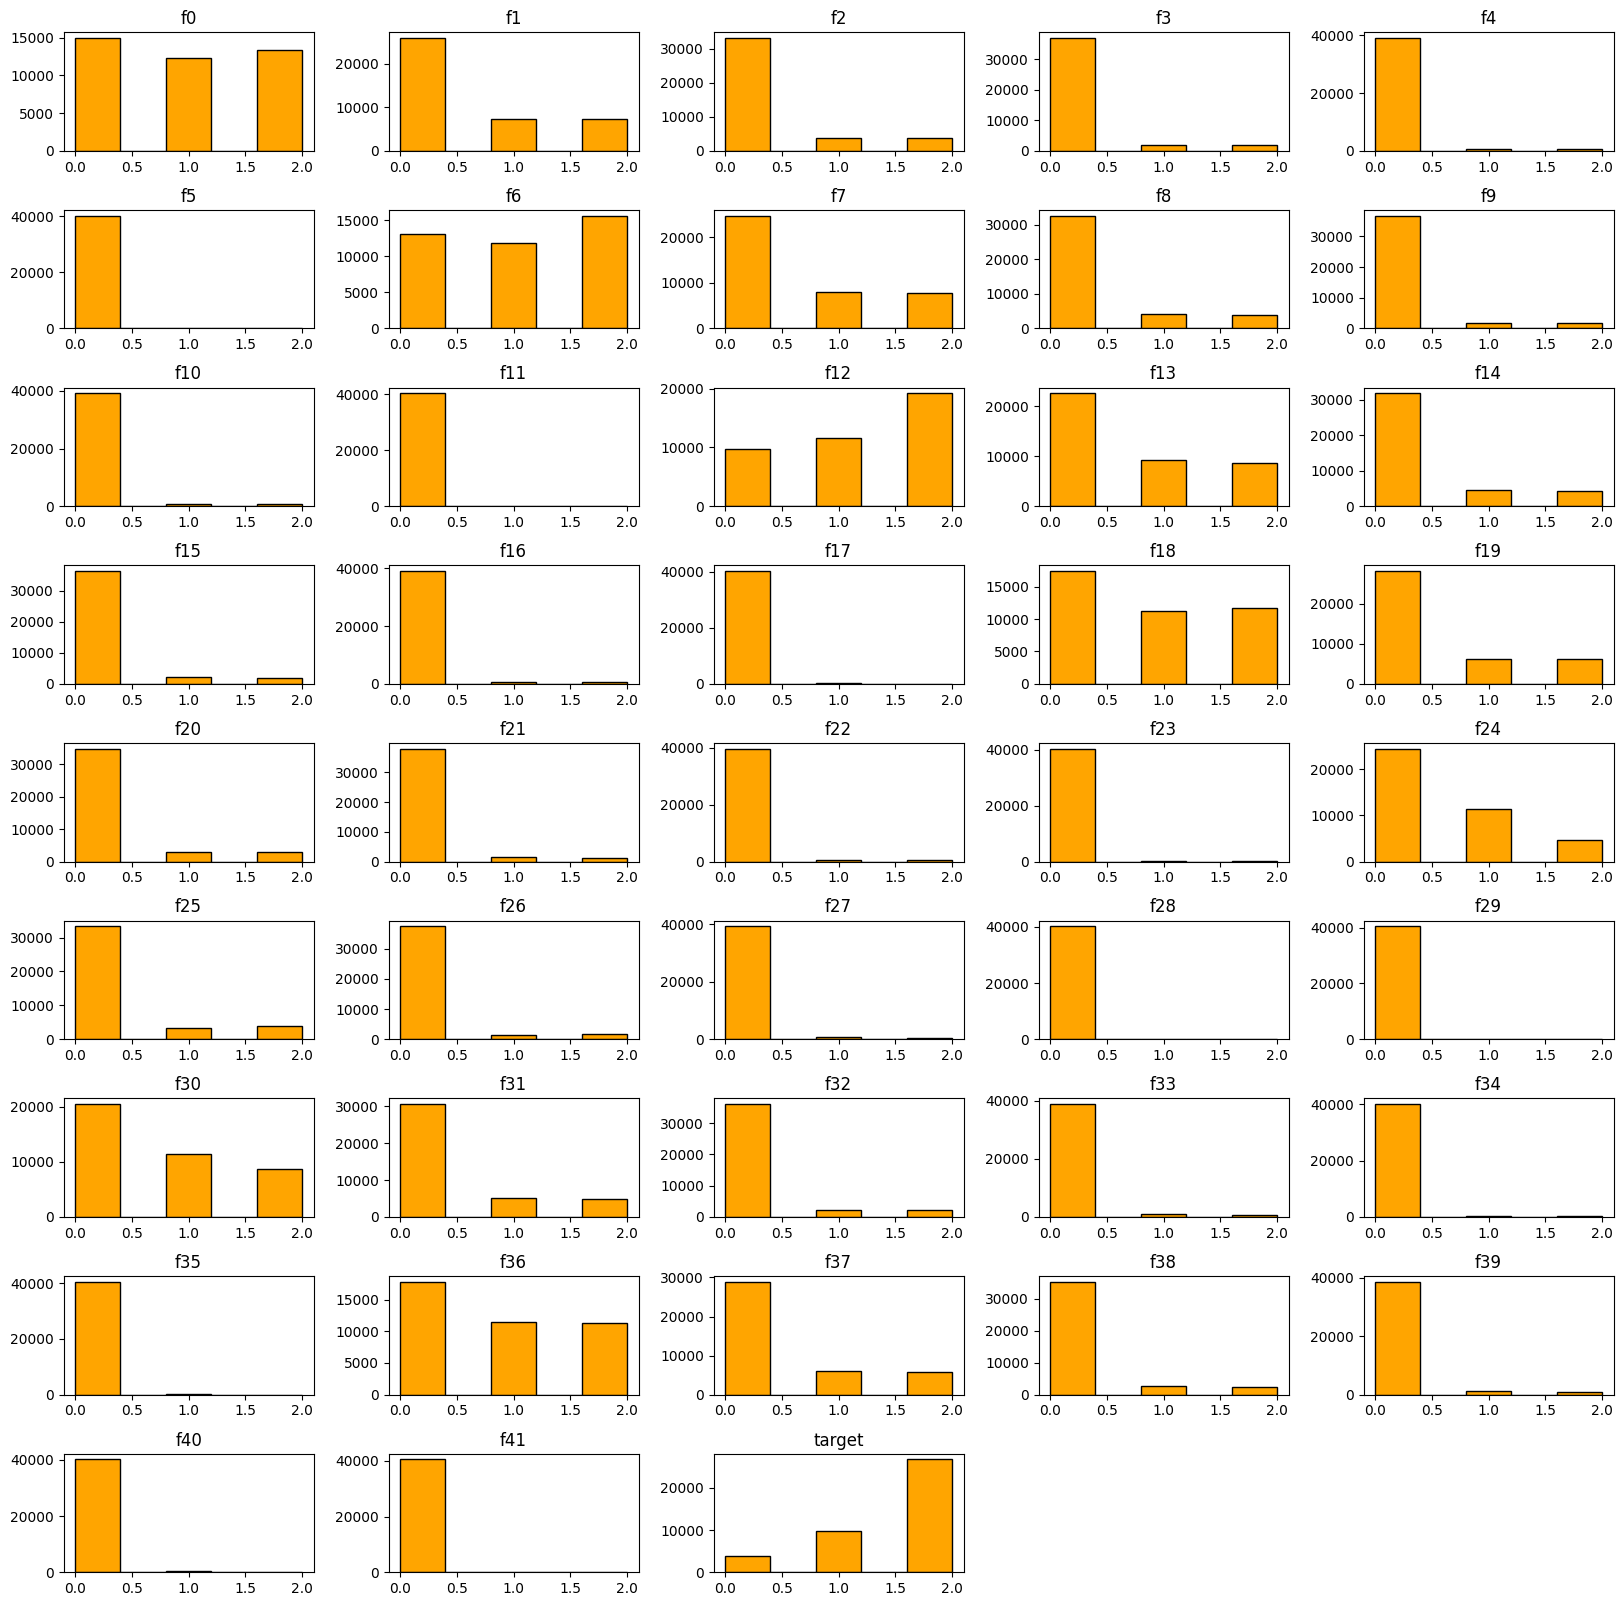

In [ ]:
# Convert data to pandas dataframes
train_df = pd.DataFrame(data['train'])

# Explore the distribution of features
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(20, 20), gridspec_kw={"hspace": 0.5, "wspace": 0.3})
axs = axs.ravel()
for i, column in enumerate(train_df.columns):
    axs[i].hist(train_df[column], bins=5, edgecolor='black', color='orange')
    axs[i].set_title(column)
    
axs[-1].set_visible(False)
axs[-2].set_visible(False)
plt.show()

in the distribution of features we can see that many are almost always 0 and barely any other values.

if computation gets too rought, we could probably shrink the dimention of our data using PCA without losing much.

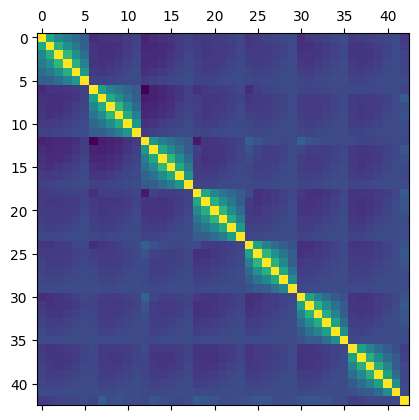

In [ ]:
# Look for correlations between features
corr_matrix = train_df.corr()
plt.matshow(corr_matrix)
plt.show()


heatmap showing correlation between different features




# Model Selection

In [5]:
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

here we concatenate the train and valdiation sets, and creates and PredefinedSplit object so that the grid search knows which examples to use for the train and which examples for the validation.


In [ ]:
models = [
          ('RandomForest', RandomForestClassifier()), 
          ('AdaBoost', AdaBoostClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('XGB', XGBClassifier()),
          ('SVC', SVC())
                        ]

Here we defined our algorithms (models) that we will check



In [ ]:
param_grid = {
    'RandomForest':{
        'n_estimators': [50,100,300],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt',15]
    },

    'AdaBoost':{
        'n_estimators': [50, 100, 300],
        'learning_rate':[0.1, 1.0, 2.0],
        'algorithm':['SAMME', 'SAMME.R']
    },

    'KNN':{
        'n_neighbors': [1,5,10],
        'p': [1,2],
        'leaf_size': [20,30,40] 
        
    },

    'XGB':{
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.3, 1.0],
    'max_depth': [6, 10]
    },

    'SVC':{
    'degree': [3, 7],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 2.0, 3.0]
    }
}

here we defined param grid dictionary, the keys are the algorithm name, and the value are dictionary where the keys are the parameter name, and the value are the inputs to those parameters

In [ ]:
best_f1_weighted_scores = []
best_accuracy_scores = []
model_names = [model[0] for model in models]

for model in models:
    grid_search = GridSearchCV(estimator=model[1], param_grid=param_grid[model[0]], cv=predefined_split,
                              scoring=['f1_weighted','accuracy'], refit = 'accuracy')
    grid_search.fit(X_train_val, y_train_val)
    cv_results = grid_search.cv_results_
    best_f1_weighted_score = max(cv_results["mean_test_f1_weighted"])
    best_accuracy_score = max(cv_results["mean_test_accuracy"])
    best_f1_weighted_scores.append(best_f1_weighted_score)
    best_accuracy_scores.append(best_accuracy_score)
    print(f"Finish with {model[0]}")

Finish with RandomForest
Finish with AdaBoost
Finish with KNN
Finish with XGB
Finish with SVC


we chose 2 matrics:

1.   accuracy score: $\frac{1}{n} \sum_{i=1}^{n} 1(y_i = \hat{y}_i)$
where n is the samples size, $y_i$ is the correct label and $\hat{y}_1$ is the model prediction

2.   f1 weighted score: its uses the precision and recall, considering the appearnce of each class in the train set. 

  Precision = $\frac{{TP}}{{TP + FP}}$, 
  Recall = $\frac{{TP}}{{TP + FN}}$ \\
  
  F1 = $2 \cdot \frac{{\text{{Precision}} \cdot \text{{Recall}}}}{{\text{{Precision}} + \text{{Recall}}}}$ \\

  and f1 weighted score (our formula) = $\frac{{\sum_{i \in \text{{classes}}}(F1_{\text{{class}}_i} \cdot \text{{count}}_{\text{{class}}_i})}}{{\sum_{i \in \text{{classes}}}\text{{count}}_{\text{{class}}_i}}}$

we used those formula because we wanted to check the accuracy of the model, conisdering the fact that its unbalace. 


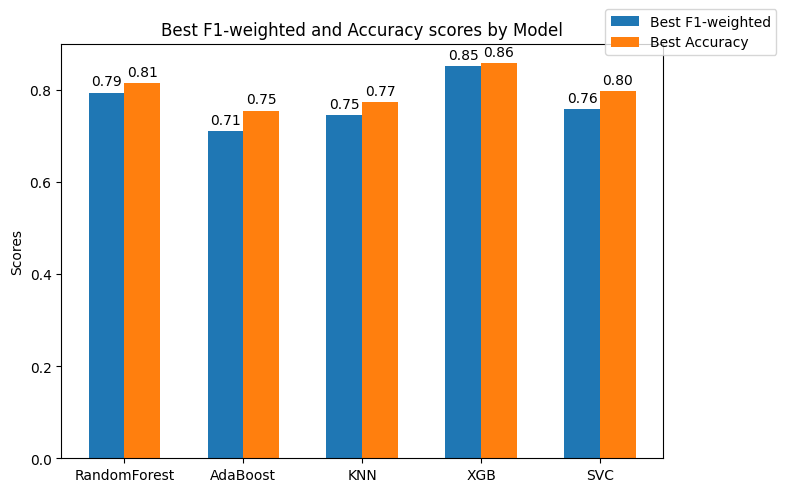

In [ ]:
x = np.arange(len(model_names))
width = 0.3  #0.2
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, best_f1_weighted_scores, width, label='Best F1-weighted')
rects2 = ax.bar(x + width/2, best_accuracy_scores, width, label='Best Accuracy')

ax.set_ylabel('Scores')
ax.set_title('Best F1-weighted and Accuracy scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),#(0,4)
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

here we checked 5 different models, and we can see that the best algorithm for our problem is the XGBClassifier

# Pre-Processing
We will do some preprocess to our data, and check if its change the behavior of our model (if it will increase the performance or reduce it)

### Select K Best features

In [ ]:
k_options = [24,36,42]
dict_of_parameters_value = {
    'n_estimators': [300, 500],
    'learning_rate': [0.3, 1.3],
    'max_depth': [6, 10],
    'subsample': [0.5, 1.0]
    }
best_f1_weighted_scores = []
best_accuracy_scores = []
for k in k_options:
    grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                              scoring=['f1_weighted','accuracy'], refit = 'accuracy')

    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train_val, y_train_val.ravel())
    X_train_val_selected = selector.transform(X_train_val)
    X_test_selected = selector.transform(X_test)
    grid_search.fit(X_train_val_selected, y_train_val)
    cv_results = grid_search.cv_results_
    best_f1_score_idx = np.argmax(cv_results["mean_test_f1_weighted"])
    best_acc_score_idx = np.argmax(cv_results["mean_test_accuracy"])
    best_f1_score_params = cv_results['params'][best_f1_score_idx]
    best_acc_score_params = cv_results['params'][best_acc_score_idx]
    best_f1_weighted_scores.append((cv_results["mean_test_f1_weighted"][best_f1_score_idx], best_f1_score_params))
    best_accuracy_scores.append((cv_results["mean_test_accuracy"][best_acc_score_idx],best_acc_score_params))
    print(f"Finish with k={k}")

Finish with k=24
Finish with k=36
Finish with k=42


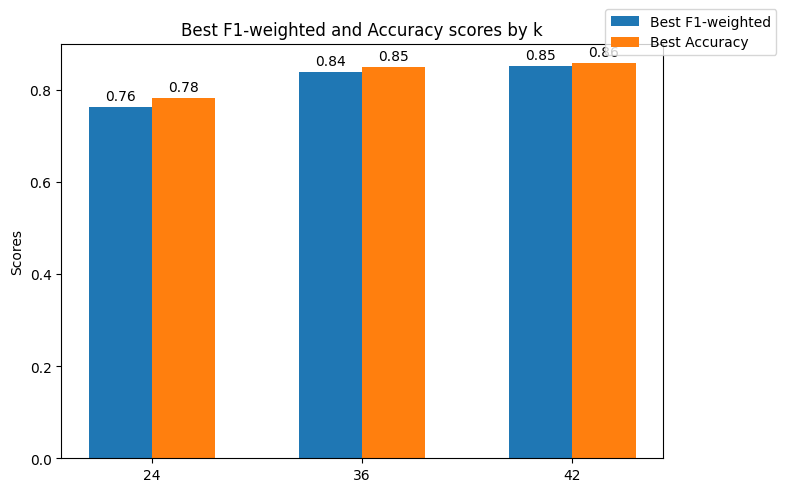

Best parameters for f1 score: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.5}
Best parameters for accuracy score: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}


In [ ]:
best_f1_scores = [score[0] for score in best_f1_weighted_scores]
best_acc_scores = [score[0] for score in best_accuracy_scores]
best_f1_params = [score[1] for score in best_f1_weighted_scores]
best_acc_params = [score[1] for score in best_accuracy_scores]
x = np.arange(len(k_options))
width = 0.3  #0.2
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, best_f1_scores, width, label='Best F1-weighted')
rects2 = ax.bar(x + width/2, best_acc_scores, width, label='Best Accuracy')

ax.set_ylabel('Scores')
ax.set_title('Best F1-weighted and Accuracy scores by k')
ax.set_xticks(x)
ax.set_xticklabels(k_options)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),#(0,4)
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

best_f1_idx = np.argmin(np.array(best_f1_scores))
best_ac_idx = np.argmin(np.array(best_acc_scores))
print(f"Best parameters for f1 score: {best_f1_params[best_f1_idx]}")
print(f"Best parameters for accuracy score: {best_acc_params[best_ac_idx]}")



here we tried to reduce the features of our samples. we can see by the graph that the our model works best when we don't remove any features from it

### Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)
dict_of_parameters_value = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 1.3],
    'max_depth': [4, 6],
    'subsample': [0.5, 1.0]
    }
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                          scoring=['f1_weighted','accuracy'], refit = 'accuracy')

grid_search.fit(X_train_val, y_train_val)
cv_results = grid_search.cv_results_
best_f1_score_idx = np.argmax(cv_results["mean_test_f1_weighted"])
best_acc_score_idx = np.argmax(cv_results["mean_test_accuracy"])
best_f1_score_params = cv_results['params'][best_f1_score_idx]
best_acc_score_params = cv_results['params'][best_acc_score_idx]
print(f"Best f1 score: {cv_results['mean_test_f1_weighted'][best_f1_score_idx]} ,with params: {best_f1_score_params}")
print(f"Best accuracy score: {cv_results['mean_test_accuracy'][best_acc_score_idx]} ,with params: {best_acc_score_params}")
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_


Best f1 score: 0.8453105017745371 ,with params: {'learning_rate': 1.3, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best accuracy score: 0.8516873889875666 ,with params: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}


### Under-Sampling

In [7]:
dict_of_parameters_value = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 1.3],
    'max_depth': [4, 6],
    'subsample': [0.5, 1.0]
    }

In [8]:
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


X_train_val = np.concatenate((X_train_resampled, X_val), axis=0)
y_train_val = np.concatenate((y_train_resampled, y_val.ravel()), axis=0)
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train_resampled.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                          scoring=['f1_weighted','accuracy'], refit = 'accuracy')

grid_search.fit(X_train_val, y_train_val)
cv_results = grid_search.cv_results_
best_f1_score_idx = np.argmax(cv_results["mean_test_f1_weighted"])
best_acc_score_idx = np.argmax(cv_results["mean_test_accuracy"])
best_f1_score_params = cv_results['params'][best_f1_score_idx]
best_acc_score_params = cv_results['params'][best_acc_score_idx]
print(f"Best f1 score: {cv_results['mean_test_f1_weighted'][best_f1_score_idx]} ,with params: {best_f1_score_params}")
print(f"Best accuracy score: {cv_results['mean_test_accuracy'][best_acc_score_idx]} ,with params: {best_acc_score_params}")
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

Best f1 score: 0.7709427581912462 ,with params: {'learning_rate': 1.3, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}
Best accuracy score: 0.7405269390171699 ,with params: {'learning_rate': 1.3, 'max_depth': 6, 'n_estimators': 500, 'subsample': 1.0}


# Hyper Parameter Selection

In [9]:
X_train = np.array(data['train'].iloc[:,:-1].values)
y_train = np.array(data['train'].iloc[:,-1:].values)
X_val = np.array(data['dev'].iloc[:,:-1].values)
y_val = np.array(data['dev'].iloc[:,-1:].values)
X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0).ravel()
test_fold = np.zeros(X_train_val.shape[0])
test_fold[:X_train.shape[0]] = -1
predefined_split = PredefinedSplit(test_fold)

In [ ]:
dict_of_parameters_value = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.3, 1.3, 2.3],
    'max_depth': [4, 6, 10],
    'subsample': [0.5, 0.75, 0.1]
    }

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=dict_of_parameters_value, cv=predefined_split,
                          scoring=['f1_weighted','accuracy'], refit = 'accuracy')
grid_search.fit(X_train_val, y_train_val)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predY = best_model.predict(X_test)
accuracy_score = accuracy_score(y_test, predY)
f1_score = f1_score(y_test, predY, average='weighted')
print(f"Best Parameters: {best_params}")
print(f"Best score: {best_score}")
print(f"Accuracy score: {accuracy_score}")
print(f"F1 weighted score: {f1_score}")

In [ ]:
gs_results = grid_search.cv_results_
param_list = gs_results['params']
f1_scores = gs_results['mean_test_f1_weighted']
acc_scores = gs_results['mean_test_accuracy']

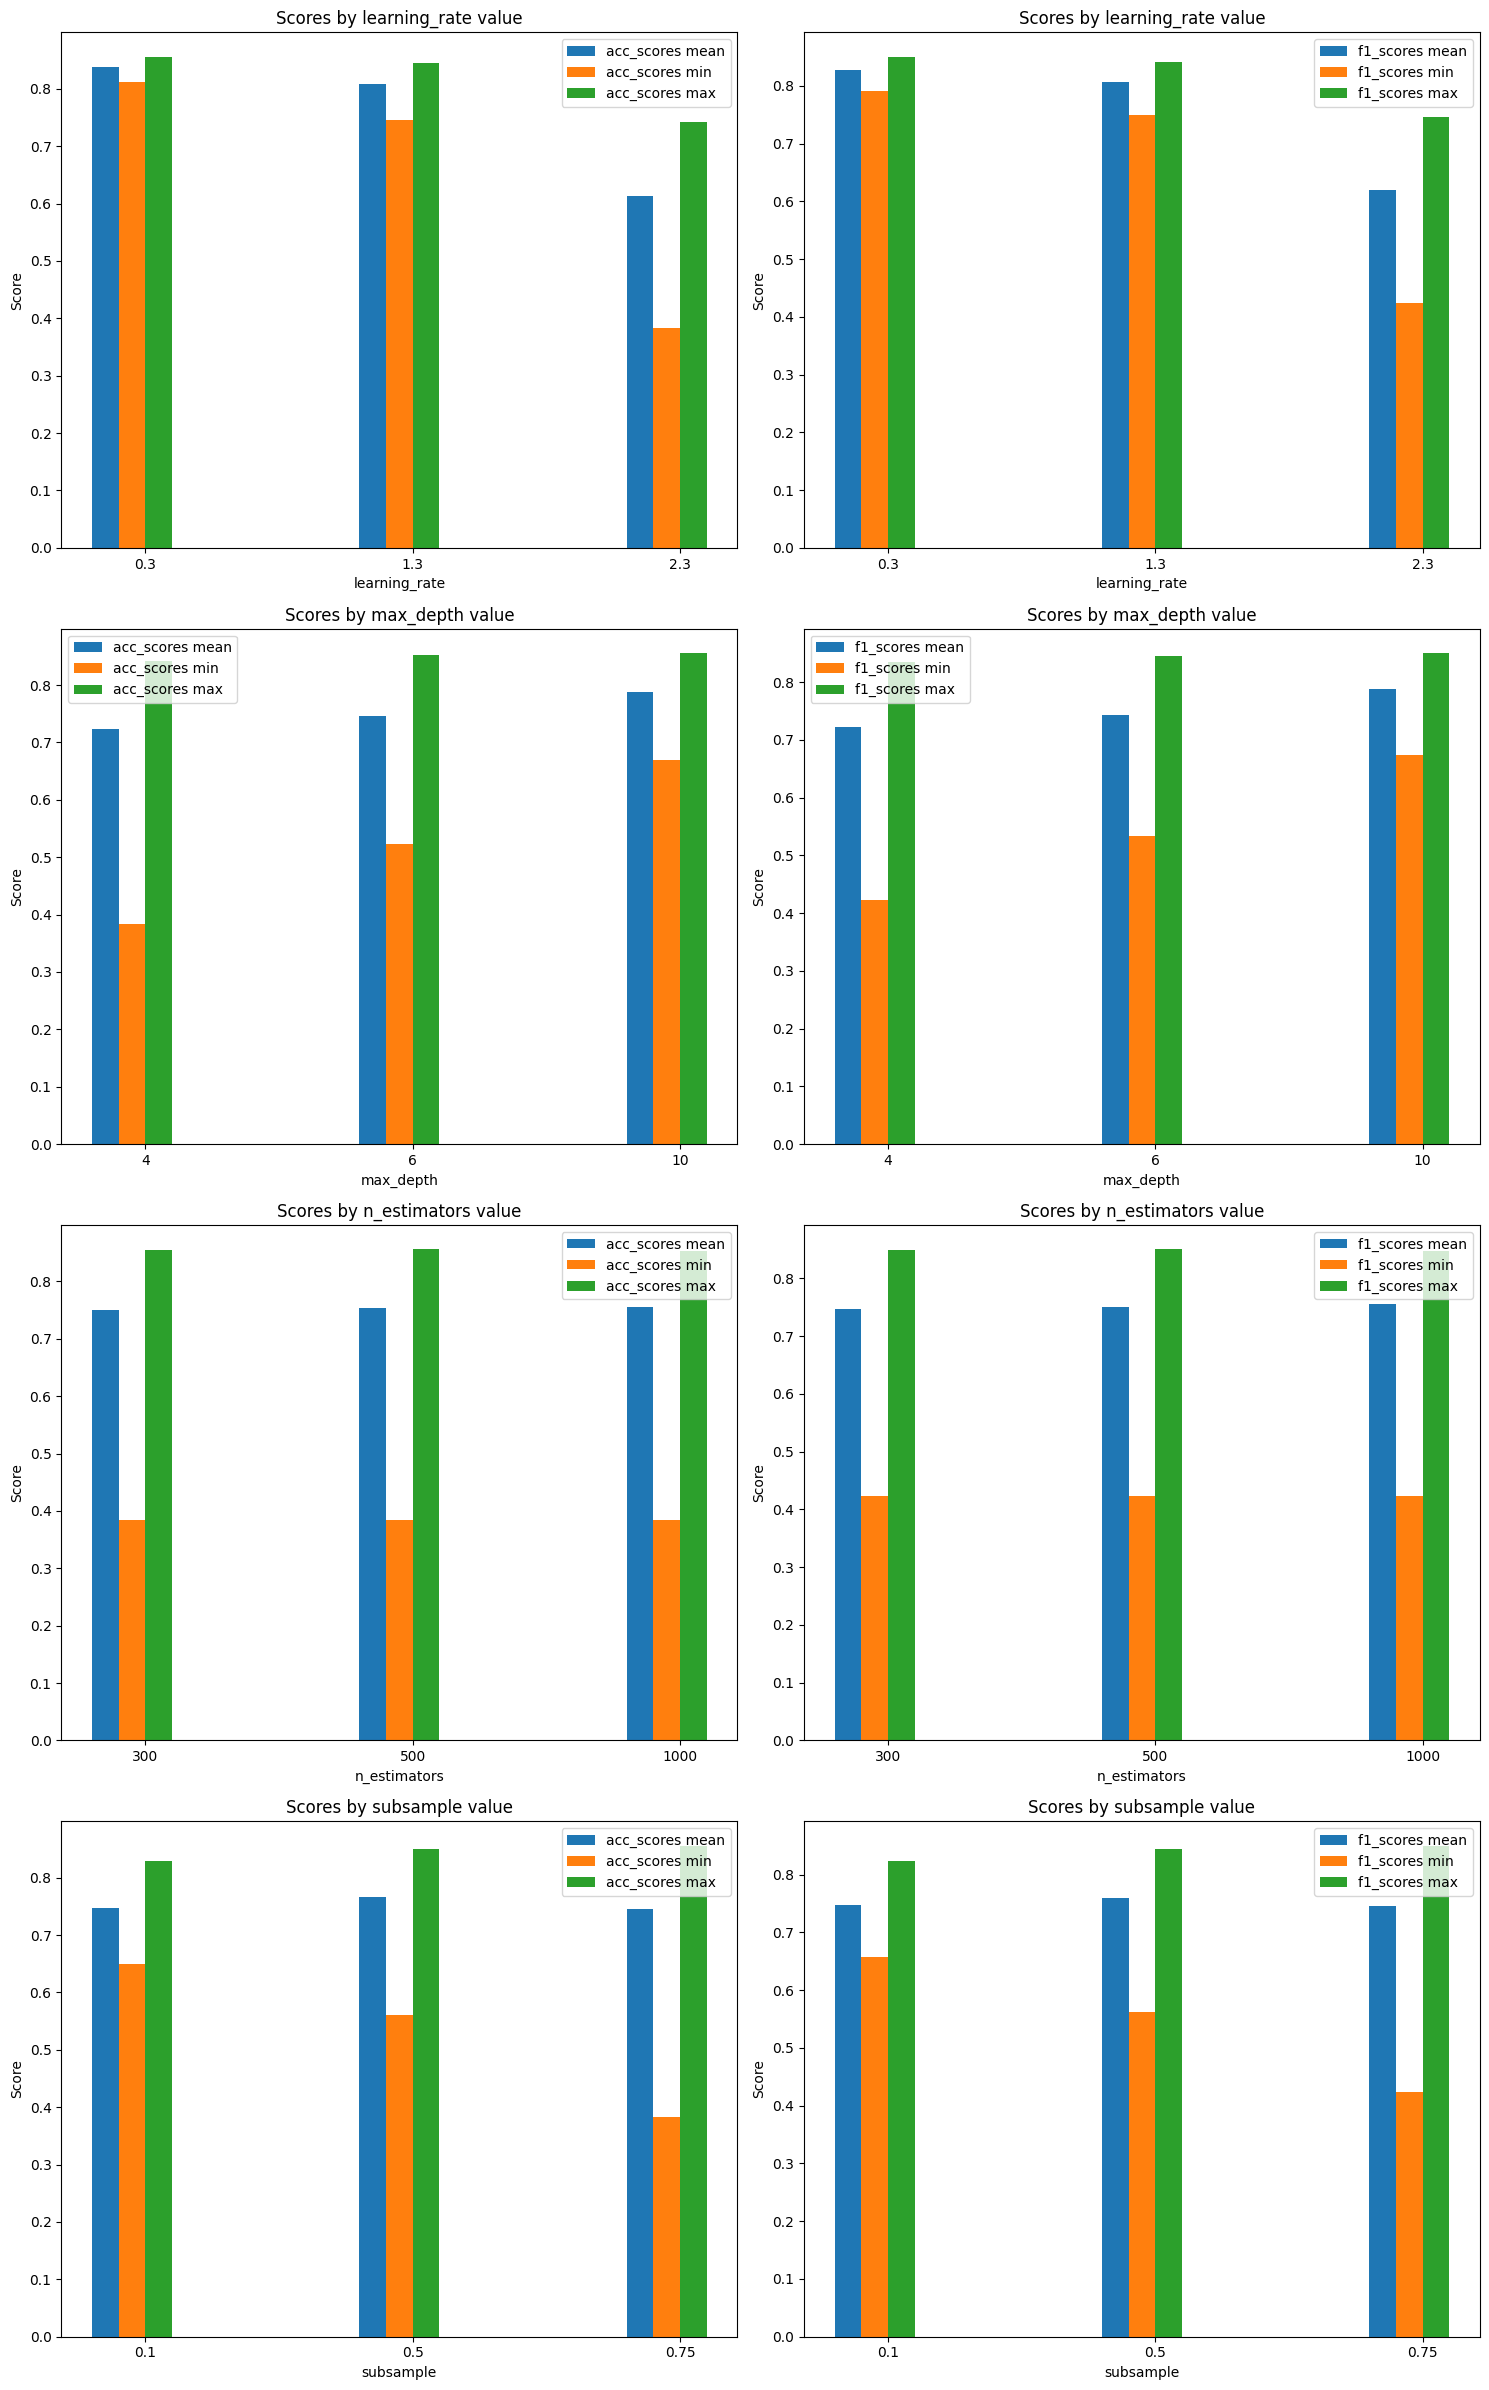

In [ ]:

param_names = list(param_list[0].keys())  # list of all parameter names
# Create a dataframe with your data
df_dict = {param: [d[param] for d in param_list] for param in param_names}
df_dict.update({'acc_scores': acc_scores, 'f1_scores': f1_scores})
df = pd.DataFrame(df_dict)

# Number of rows and columns for the subplot grid
nrows = len(param_names)
ncols = 2  # for 'acc_scores' and 'f1_scores'

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 6*nrows))

for row, param_name in enumerate(param_names):
    # Group by the parameter values and calculate mean, min, and max
    grouped = df.groupby(param_name).agg(['mean', 'min', 'max'])

    # Create an array with indices for each unique parameter value
    indices = np.arange(len(grouped))

    # Set the width of each bar
    bar_width = 0.1 

    for col, metric in enumerate(['acc_scores', 'f1_scores']):
        ax = axs[row, col]
        # Plot the mean, min, and max scores
        for i, stat in enumerate(['mean', 'min', 'max']):
            ax.bar(indices + i * bar_width, grouped[metric][stat], bar_width, label=metric + ' ' + stat)

        # Set the x-ticks to be in the center of each group of bars
        ax.set_xticks(indices + 1.5 * bar_width)

        # Set the x-tick labels to be the unique parameter values
        ax.set_xticklabels(grouped.index)

        ax.legend()

        ax.set_xlabel(param_name)
        ax.set_ylabel('Score')
        ax.set_title('Scores by ' + param_name + ' value')

plt.tight_layout()
plt.show()

In [ ]:
grid_search.cv_results_

# Final testing